In [1]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpenCVDNN = frame.copy()
    frameHeight = frameOpenCVDNN.shape[0]
    frameWidth = frameOpenCVDNN.shape[1]
    blob = cv.dnn.blobFromImage(
        frameOpenCVDNN, 1.0, (300, 300), [104, 117, 123], True, False
    )

    net.setInput(blob)
    detections = net.forward()
    faces = []

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)

            faces.append([x1, y1, x2, y2])
            
            cv.rectangle(
                frameOpenCVDNN,
                (x1, y1),
                (x2, y2),
                (0, 255, 0),
                int(round(frameHeight / 150)),
                8,
            )
    return frameOpenCVDNN, faces

In [4]:
faceProto = "pretrained_models/opencv_face_detector.pbtxt"
faceModel = "pretrained_models/opencv_face_detector_uint8.pb"
ageProto = "pretrained_models/age_deploy.prototxt"
ageModel = "pretrained_models/age_net.caffemodel"
genderProto = "pretrained_models/gender_deploy.prototxt"
genderModel = "pretrained_models/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

ageList = [
    "(0-2)",
    "(4-6)",
    "(8-12)",
    "(15-20)",
    "(25-32)",
    "(38-43)",
    "(48-53)",
    "(60-100)",
]

genderList = ["Male", "Female"]

In [5]:
ageNet = cv.dnn.readNet(ageModel, ageProto)
genderNet = cv.dnn.readNet(genderModel, genderProto)
faceNet = cv.dnn.readNet(faceModel, faceProto)
padding = 20

def age_gender_detector(frame):
    frameFace, faces = getFaceBox(faceNet, frame)
    for bbox in faces:
        face = frame[
            max(0, bbox[1] - padding) : min(bbox[3] + padding, frame.shape[0] - 1),
            max(0, bbox[0] - padding) : min(bbox[2] + padding, frame.shape[1] - 1),
        ]

        blob = cv.dnn.blobFromImage(
            face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False
        )

        genderNet.setInput(blob)
        genderPreds = genderNet.forward()
        gender = genderList[genderPreds[0].argmax()]

        print("Gender: {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

        ageNet.setInput(blob)
        agePreds = ageNet.forward()
        age = ageList[agePreds[0].argmax()]

        print("Age: {}, conf = {:.3f}".format(age, agePreds[0].max()))

        label = f"{gender}, {age}"
        cv.putText(
            frameFace,
            label,
            (bbox[0], bbox[1] - 10),
            cv.FONT_HERSHEY_DUPLEX,
            0.5,
            (0, 255, 255),
            2,
            cv.LINE_AA,
        )
    return frameFace


In [6]:
def show_results(img_path):
    img = cv.imread(img_path)
    output = age_gender_detector(img)
    rgb_output = cv.cvtColor(output, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_output)
    plt.show()

Gender: Male, conf = 0.997
Age: (38-43), conf = 0.776


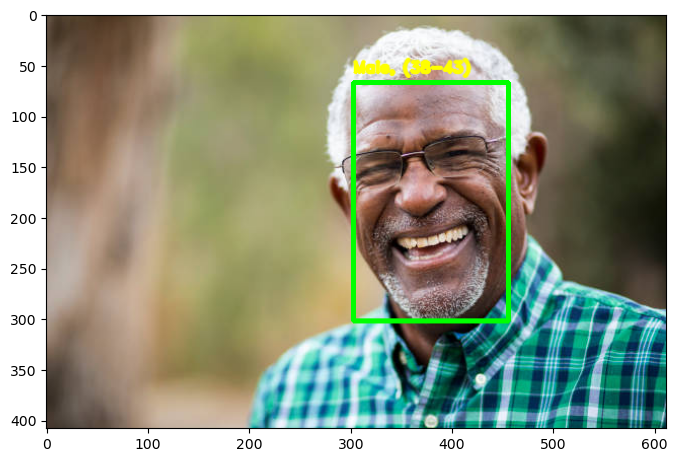

In [7]:
show_results('Sample Images/man1.jpg')